Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

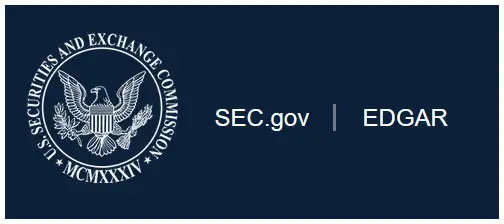
# EDGAR Competitor Analysis using Knowledge Graph, Graph Algorithms, and Vector Search

Investors and analysts commonly review 13F filings to track the investment activities and holdings of some of the highest profile hedge funds, asset managers, pensions funds, and others required to file. Comparing filings quarter-over-quarter can provide clues to investment themes or sectors that institutions are increasing or decreasing their exposure to. While 13F data does have some limitations, it remains one of the most readily accessible sources of information on where major institutional money is being allocated in U.S. equity markets each quarter.

In this notebook we will be looking at data from the [EDGAR system](https://www.sec.gov/edgar/search-and-access) to demonstrate how to leverage, graphs, graph analytics, and vector similarity to perform investment analysis of stock holdings.

EDGAR 13F data refers to quarterly institutional investment manager filings that are made with the Securities and Exchange Commission (SEC) through its [EDGAR system](https://www.sec.gov/edgar/search-and-access). Institutional investment managers that exercise investment discretion over $100 million or more in Section 13(f) securities are required to file a Form 13F report within 45 days after the end of each calendar quarter. Section 13(f) securities generally include most equity securities that are traded on a U.S. national securities exchange, as well as shares of certain exchange-traded funds and American Depositary Receipts. Each hedge funds, individuals, and/or businesses must say how many shares they are holding and the value at the end of the quarter.

## Creating the Graph

To use this dataset you need to create a graph that has a vector search index with a dimension of 384.  This must be done prior to running the load commands below.  

This can be done using a command similar to the one below, which can be run from a client that has the AWS CLI configured and appropriate permissions.  Please refer to the [documentation](https://docs.aws.amazon.com/neptune/) for the details on setting up a vector search enabled graph.

```
aws neptune-graph create-graph --graph-name 'edgar' --provisioned-memory 128 --allow-from-public --replica-count 0 --vector-search '{"dimension": 384}'
```

<div class="alert alert-block alert-info"> 
<details>
    <summary>✏️<b><i> Click here for a tip</i></b></summary>
  
If you need to change the graph that this notebook points to please look at the `%graph_notebook_config` and `%graph_notebook_host` magics, which are described [here](https://github.com/aws/graph-notebook/tree/main).  
</details>
</div>

## The Data Model

The data used in this notebook was retrieved from EDGAR during the 4th quarter of 2023.  This information is a representative subset of the data for this quarter which we turned into a knowledge graph representing businesses, fiscal quarters, and holdings in those quarters.  The data model used in this example is below:

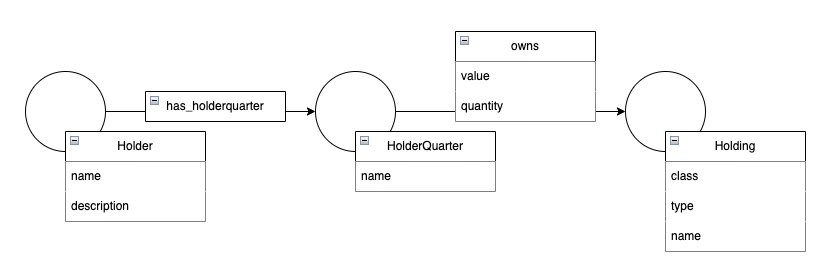

This data model has several key elements:

* `Holder` - This represents the business or entity that is making the filing.  Each node contains a `name` and `description` attribute, which was provided by Bedrock.  This description was then used to generate a vector embedding of the description.  The id of the node represents the `CIK` value which is an SEC assigned identified.

* `HolderQuarter` - This represents the quarter, the name represents the quarter (i.e. `2023Q2`) and the id is a combination of the quarter and id value of the `Holder`.

* `Holding` - This represents the security owned by the `Holder` in the `HolderQuarter`.  This contains a `class`, `type`, and `name` attribute.

* `has_holderquarter` - This represents a fiscal quarter in which the `Holder` had reportable investments.

* `owns` - This represents a security owned by a `Holder` in a `HolderQuarter`.  This contains a `quantity` and `value` attribute, which represents the number and value of the shares owned by the `Holder` in a `HolderQuarter`.


### Load data
The cell below loads the EDGAR data into your graph. When you run the cell below, a graph will load, which will take 1-2 minutes to load.

To load this dataset, run the two cells below.  This first cell will setup a few python variables using the configuration parameters of this Neptune Notebook.  The second cell will use Neptune Analytics bulk load feature to load the data from the provided S3 bucket.  

**Note:** You only need to do this once. If you have already loaded the data previously you do not need to load it again.

In [50]:
import graph_notebook as gn
config = gn.configuration.get_config.get_config()

s3_bucket = f"s3://aws-neptune-customer-samples-{config.aws_region}/sample-datasets/gremlin/edgar/"
region = config.aws_region
load_arn = config.load_from_s3_arn

In [ ]:
%%oc

CALL neptune.load({format: "csv", 
                   source: "${s3_bucket}", 
                   region : "${region}"})

Now that we have all our data loaded let's begin by looking at the type of competitive analysis we can perform on this knowledge graph model.

## Finding Similar Investment Portfolios

For our example here let's investigate how similar the portfolios of the largest investment firms are to one another.  This will allow us to perform a competitive analysis 

To start, let's first find the biggest investors, based on value and store this information into a Python variable `investor` using the `--store-to` flag on the query.  This will allow us to reuse these value in later analysis.

### Find the top 10 companies with the largest holdings

In [ ]:
%%oc --store-to data
MATCH (h:Holder)-->(hq:HolderQuarter)-[o:owns]->(holdings:Holding)
WHERE hq.name = '2023Q4'
RETURN h.name, id(hq) as hq_id, sum(o.value) as total_value 
ORDER BY total_value DESC LIMIT 10

Now that we have retrieved the top 10 companies, let's take a moment to setup a python variable `params` with the id of our top investor and the other 9.  We will use this later on for performing further analysis.

In [ ]:
lst =data['results']
params = {'hq_id': lst[0]['hq_id'], 'competitors': [l['hq_id'] for l in lst[-9:]]}
print(params)

Using the values above we will now be able to pass these in as parameters to our future queries.  This will not only simplify the queries but it will allow the engine to process them more efficiently.

### Investigating the Top Investor

Now that we have our top 10 investors, let's find out how many holdings the top investor owns, to accomplish this we can use the Degree Centrality algorithm to find the number of outbound edges, which represent the `owns` connections to the `Holdings` node.

In [ ]:
%%oc -qp params
MATCH (hq:HolderQuarter)
WHERE id(hq) = $hq_id
CALL neptune.algo.degree(hq, { traversalDirection: "outbound" } )
YIELD degree
RETURN  degree

Now that we know that the top investor owns 10's of thousands of different securities, let's take a bit of a deeper look at some of the securities that they are most heavily invested by looking at the top 10 investments they own.

In [ ]:
%%oc -qp params
MATCH (hq:HolderQuarter)-[o:owns]->(h:Holding)
WHERE id(hq) = $hq_id
RETURN h.name, o.value
ORDER by o.value DESC LIMIT 10

Now that we have seen their top investments, let's find all the investments where they have >$1B USD invested.

In [ ]:
%%oc -qp params
MATCH (hq:HolderQuarter)-[o:owns]->(h:Holding)
WHERE id(hq) = $hq_id
AND o.value > 1000000000
RETURN h.name, o.value
ORDER by o.value DESC

## Compare our top investor against competitors

Up until now we have been looking specifically at the investments made by our top investor.  Now let's see how their investments compare to those of their top competitors.  To do this we can approach this using two different mechanisms.

First, let's take a look at the overall number of shared `Holding`'s where each investor has invested >$1B USD.

In [ ]:
%%oc -qp params
MATCH (hq:HolderQuarter)-[o:owns]->(h:Holding)
WHERE id(hq) = $hq_id
AND o.value > 1000000000
WITH h
MATCH (h)<-[o:owns]-(co_hq)<--(coholder:Holder)
WHERE id(co_hq) IN $competitors
AND o.value > 1000000000
WITH coholder.name as name, collect(DISTINCT h.name) as coholdings
RETURN name, size(coholdings) as number_shared, coholdings
ORDER BY number_shared DESC

With this information we are able to see the securities where the top investors are co-investing.  Looking at the list we see some common tech stocks, such as Alphabet Inc. and Amazon, but we also notice quite a bit of variability as these competitors are investing significant portions of money in different securities >50% of their portfolio.

Another way to look at the similarities between investments here would be too use a more holistic approach and compare all the stocks and investments, not just the ones where they have significant investments.  To do this we will look to use a graph algorithm, known as Jaccard Similarity.  Jaccard similarity measures the similarity between two sets. It is calculated by dividing the size of the intersection of the two sets by the size of their union. By measuring the proportion of shared neighbors relative to the total number of unique neighbors, this algorithm provides a metric for the degree of overlap or commonality between different parts of a network. 

Let's see what this looks like for our top investors by find the most similar investment portfolios.

<div class="alert alert-block alert-info"> 
<details>
    <summary>✏️<b><i> Click here for a tip</i></b></summary>
  
In Jaccard similarity, the higher the number the more similar the two items. 
</details>
</div>

In [ ]:
%%oc -qp params
MATCH (hq:HolderQuarter)<--(holder:Holder)
WHERE id(hq) = $hq_id
MATCH (co_hq:HolderQuarter)<--(coholder:Holder)
WHERE id(co_hq) IN $competitors
CALL neptune.algo.jaccardSimilarity(hq, co_hq)
YIELD score
RETURN holder.name, coholder.name, score
ORDER BY score DESC

If we compare the rankings of our similarity comparison to the rankings from our previous query where we looked for overlapping large investments, we see that the results are very similar, but do have some differences.  Let's actually take this one step further and look at how all the investors in our dataset compare, not just the top investors.

In [ ]:
%%oc -qp params
MATCH (hq:HolderQuarter)<--(holder:Holder)
WHERE id(hq) = $hq_id
MATCH (co_hq:HolderQuarter)<--(coholder:Holder)
WHERE NOT id(co_hq) = $hq_id
CALL neptune.algo.jaccardSimilarity(hq, co_hq)
YIELD score
RETURN holder.name, coholder.name, score
ORDER BY score DESC LIMIT 10

Looking at these results, we see that while many of the ten most similar were also top investors.

Up until now we have been using graph traversals and graph algorithms to perform a comparison of investments based on the information in our knowledge graph.  One additional way to look at competitors is by looking at similar companies, not just similar portfolios.  To accomplish this in Neptune Analytics we can use Vector Similarity to find the most similar companies based on a vector comparison.  In this case our `Holder` nodes each contain a vector embedding representing a dense data representation of the company description, as sourced from Amazon Bedrock.  

## Vector Similarity Search (VSS) + Graph Traversals

To accomplish this search we will use Neptune Analytic's native vector index and openCypher query integration.  Let's start similarly to how we started our previous investment analysis, by finding the top 10 most similar `Holder` nodes to our top investor. 

In [ ]:
%%oc -qp params
MATCH (n:Holder)-->(hq)
WHERE id(hq) = $hq_id
CALL neptune.algo.vectors.topKByNode(n)
YIELD node, score
RETURN node.name

Comparing this against our earlier search for top competitors, we see that there is only a minimal overlap between these results.  Which is to be expected.  Our earlier search found competitors based on the investment portfolio.  This example found competitors based on a company description.  Both options provide valuable competitor analysis, however each defines "similarity" using different facets of the investors.

Let's repeat some of the investigations we did before using our vector based competitors starting with the number of shared holdings >$1B USD.

In [ ]:
%%oc -qp params

MATCH (h:Holder)-->(hq)
WHERE id(hq) = $hq_id
WITH h
CALL neptune.algo.vectors.topKByNode(h)
YIELD node, score
WHERE score > 0
WITH node as coholder LIMIT 10
MATCH (holding)<-[o:owns]-(hq)<--(coholder:Holder)
WHERE hq.name = '2023Q4' AND o.value > 10000000000
WITH coholder.name as name, collect(DISTINCT holding.name) as coholdings
RETURN name, size(coholdings) as number_shared, coholdings
ORDER BY number_shared DESC

As we see from the data above, this is quite a different set of results from what we found by comparing portfolios.  

To round out our investigation, let's calculate the Jaccard Similarity of these similar companies portfolios.

In [ ]:
%%oc -qp params
MATCH (holder:Holder)-->(hq)
WHERE id(hq) = $hq_id
WITH holder, hq
CALL neptune.algo.vectors.topKByNode(holder)
YIELD node, score as s
WHERE s > 0
MATCH (node)-->(co_hq)
WHERE co_hq.name = '2023Q4'
CALL neptune.algo.jaccardSimilarity(hq, co_hq)
YIELD score
RETURN holder.name, node.name, score
ORDER BY score DESC LIMIT 10

## Conclusion

This notebook has shown how you can use Amazon Neptune Analytics to run analytics on your EDGAR data investigate investments. We've used graph traversals and algorithms to identify the top investors for the specified quarter and identified similarities and overlaps in investment portfolios.  We then used vector similarity search to identify the most similar investors to our top investor and look at those competitors for similarities in the investment portfolio.

Investment analysis is an ongoing process.  The faster a team can identify patterns in competitive behavior the faster then can look at how to use those patterns to increase gains while minimizing losses. Combining the ability to query a graph with the ability to run network analysis, graph algorithms, and vector search on top of that data enables us to derive novel insights from this data. 